In [70]:
# !pip install imbalanced-learn
# !pip install --upgrade pandas
# !pip install optuna
# !pip install xgboost

     |████████████████████████████████| 2.2 MB 725 kB/s eta 0:00:01


In [71]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
import pickle
import optuna
from xgboost import XGBClassifier

from company_data_extractor import company_data_extractor

warnings.filterwarnings('ignore')

In [37]:
# Load Data
dataset = pd.read_csv("Stock_data.csv")

In [38]:
num_dataset = dataset.select_dtypes(include=[np.number])

In [39]:
# Null value analysis
dataset.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 179 columns):
 #    Column                                                Non-Null Count  Dtype  
---   ------                                                --------------  -----  
 0    year                                                  4800 non-null   int64  
 1    adjDividend                                           4800 non-null   float64
 2    dps_growth                                            4800 non-null   float64
 3    dps_growth_rate                                       4800 non-null   float64
 4    industry                                              4800 non-null   object 
 5    sector                                                4800 non-null   object 
 6    companyRating                                         4800 non-null   float64
 7    companyRating_percentage_change                       4800 non-null   float64
 8    companyRating_actual_change                   

In [40]:
# Multivariate Analysis

# Correlation matrix
correlation_matrix = num_dataset.corr()

def rank_columns_by_correlation(df, threshold=0.9):
    # Calculating correlation matrix
    corr_matrix = df.corr()
    # Initializing a list to hold the tuples (col1, col2, correlation)
    correlations = []
    # Iterating over the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):  # avoiding duplicate and self-correlation
            # Including only correlations above the specified threshold
            if abs(corr_matrix.iloc[i, j]) > threshold:
                correlations.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    # Sorting the list by absolute correlation in descending order
    sorted_correlations = sorted(correlations, key=lambda x: abs(x[2]), reverse=True)
    correlation_df = pd.DataFrame(sorted_correlations, columns=['Column1', 'Column2', 'Correlation'])
    return correlation_df

top_correlations = rank_columns_by_correlation(num_dataset, 0.95)

# Remove highly correlated columns
columns_to_remove = top_correlations["Column2"].unique()
dataset.drop(columns_to_remove, axis="columns", inplace=True)

In [42]:
# Data Preprocessing
# Missing value
dataset.info(verbose=True, show_counts=True)
dataset.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 136 columns):
 #    Column                                                Non-Null Count  Dtype  
---   ------                                                --------------  -----  
 0    year                                                  4800 non-null   int64  
 1    adjDividend                                           4800 non-null   float64
 2    dps_growth                                            4800 non-null   float64
 3    dps_growth_rate                                       4800 non-null   float64
 4    industry                                              4800 non-null   object 
 5    sector                                                4800 non-null   object 
 6    companyRating                                         4800 non-null   float64
 7    companyRating_percentage_change                       4800 non-null   float64
 8    companyRating_actual_change                   

In [43]:
# First let's leave out the last year's data as future test data, and 2021's data as validation data
training_data = dataset.loc[(dataset["year"] != 2022) & (dataset["year"] != 2021)]
validation_data = dataset.loc[dataset["year"] == 2021]
testing_data = dataset.loc[dataset["year"] == 2022]


# Predictor - Target Split
X_train = training_data.drop("dps_change_next_year", axis="columns")
y_train = training_data["dps_change_next_year"]
X_test = testing_data.drop("dps_change_next_year", axis="columns")
y_test = testing_data["dps_change_next_year"]
X_validate = validation_data.drop("dps_change_next_year", axis="columns")
y_validate = validation_data["dps_change_next_year"]

In [45]:
# Encoding our categorical features - The reason we are encoding them is that not all algorithms support
# categorical predictors.

# Define categorical features
categorical_columns = ["industry", "sector", "symbol"]
other_columns = [col for col in X_train.columns if col not in categorical_columns]

# Label encode categorical features with many categories
column_transformer = ColumnTransformer(
    transformers=[
        ('categorical', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns)
    ],
    remainder='passthrough'
)

X_train_transformed = column_transformer.fit_transform(X_train)
X_validate_transformed = column_transformer.transform(X_validate)
X_test_transformed = column_transformer.transform(X_test)

# Note: after transformation, the output will be a numpy array and column orders will be changed.
X_train_transformed = pd.DataFrame(X_train_transformed, columns=categorical_columns + other_columns)
X_validate_transformed = pd.DataFrame(X_validate_transformed, columns=categorical_columns + other_columns)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=categorical_columns + other_columns)

# Check our data type
X_train_transformed.info(verbose=True, show_counts=True)

# Let's change our data types back to their original forms - However, this time, categorical variables have become
# number like strings
cols_to_convert = {'industry': 'str', 'sector': 'str', 'symbol': 'str', 'year': 'int'}
X_train_transformed = X_train_transformed.astype(cols_to_convert)
X_validate_transformed = X_validate_transformed.astype(cols_to_convert)
X_test_transformed = X_test_transformed.astype(cols_to_convert)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840 entries, 0 to 3839
Data columns (total 135 columns):
 #    Column                                                Non-Null Count  Dtype  
---   ------                                                --------------  -----  
 0    industry                                              3840 non-null   float64
 1    sector                                                3840 non-null   float64
 2    symbol                                                3840 non-null   float64
 3    year                                                  3840 non-null   float64
 4    adjDividend                                           3840 non-null   float64
 5    dps_growth                                            3840 non-null   float64
 6    dps_growth_rate                                       3840 non-null   float64
 7    companyRating                                         3840 non-null   float64
 8    companyRating_percentage_change               

In [47]:
# Check data imbalance
# Let's add target back to our dataset for further analysis
training_data_transformed = pd.concat([X_train_transformed, y_train], axis=1)
training_data_transformed["dps_change_next_year"].value_counts()

# Let's do some over sampling

# Perform oversampling using SMOTE
categorical_indices = [X_train_transformed.columns.get_loc(col) for col in categorical_columns]
smote = SMOTENC(random_state=1, categorical_features=categorical_indices)

X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_transformed, y_train)
# Check our training data
pd.DataFrame(y_train_oversampled)["dps_change_next_year"].value_counts()
X_train_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7246 entries, 0 to 7245
Columns: 135 entries, industry to enterpriseValueMultiple_actual_change
dtypes: float64(131), int64(1), object(3)
memory usage: 7.5+ MB


feature 0's importance score: 0.002611378106141732 (industry)
feature 1's importance score: 0.015874064698638796 (sector)
feature 2's importance score: 0.0024203993771546926 (symbol)
feature 3's importance score: 0.0025293744441537242 (year)
feature 4's importance score: 0.008667427225879341 (adjDividend)
feature 5's importance score: 0.14765664210346988 (dps_growth)
feature 6's importance score: 0.03057741564255663 (dps_growth_rate)
feature 7's importance score: 0.022079745005811592 (companyRating)
feature 8's importance score: 0.02561477449573684 (companyRating_percentage_change)
feature 9's importance score: 0.046206897074405555 (companyRating_actual_change)
feature 10's importance score: 0.023817468939737886 (interestRate)
feature 11's importance score: 0.008167308732181827 (interestRate_percentage_change)
feature 12's importance score: 0.003860072762144592 (interestRate_actual_change)
feature 13's importance score: 0.009430257532780402 (inflationRate)
feature 14's importance score

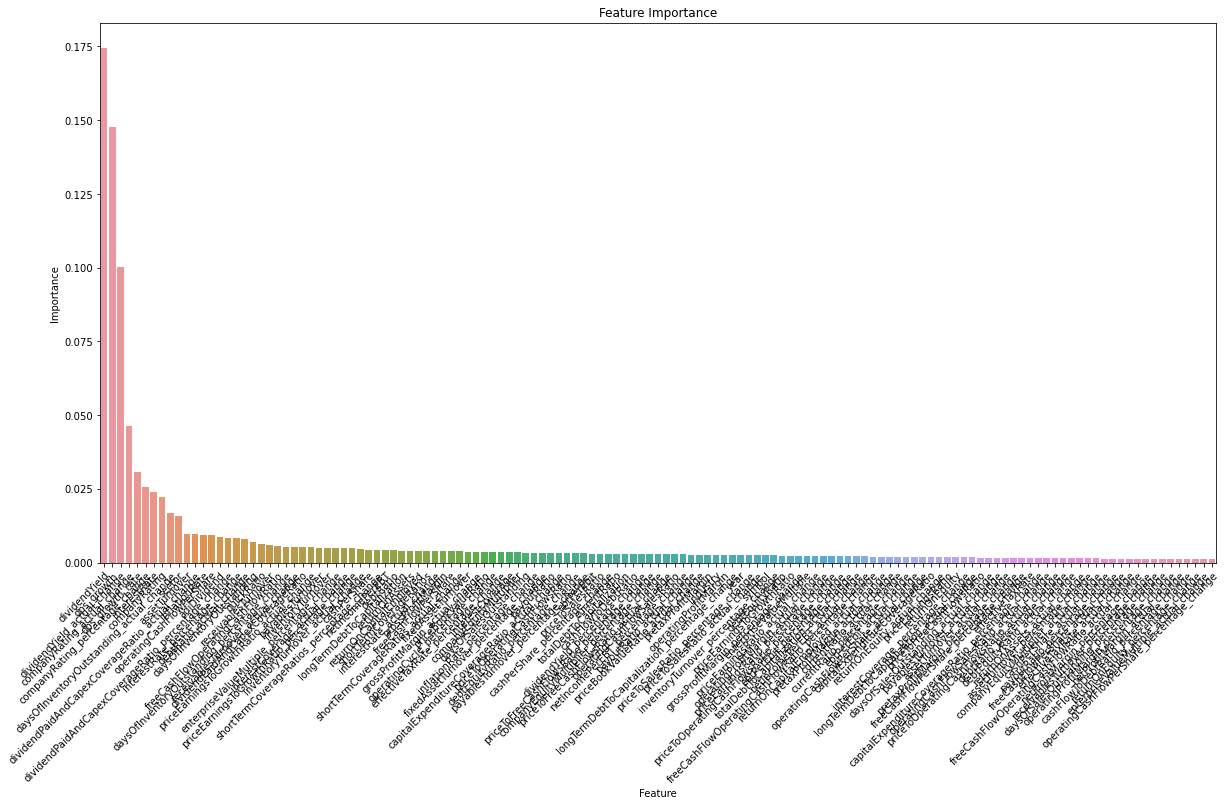

In [55]:

# Feature selection

# Feature importance analysis - Tree Based
randomForestModel = RandomForestClassifier(max_features=None)  # We want all features to be considered for each tree
randomForestModel.fit(X_train_oversampled, y_train_oversampled)
model_importance = randomForestModel.feature_importances_
importance_table = pd.DataFrame(columns=["Feature", "Importance"])  # Create an importance table to plot bar chart
featureNum = 0
for score in model_importance:
    print("feature " + str(featureNum) + "'s importance score: " + str(score) + " (" + X_train_oversampled.columns[featureNum] + ")")
    rowAdded = pd.DataFrame([[X_train_oversampled.columns[featureNum], score]], columns=["Feature", "Importance"])
    importance_table = pd.concat([importance_table, rowAdded])
    featureNum = featureNum + 1
importance_table.sort_values('Importance', inplace=True, ascending=False)
# Plot a bar chart to visualize feature importance
plt.figure(figsize=(20, 10))
sns.barplot(data=importance_table, x="Feature", y="Importance")
plt.title("Feature Importance")
plt.subplots_adjust(bottom=0.2, top=0.95)
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.savefig('feature.png')
plt.show()

In [64]:
# Now let's remove the features one by one from the least important one
X_train_temp = X_train_oversampled.copy()
X_validate_temp = X_validate_transformed.copy()

# Initialize the result dataframe
result_df = pd.DataFrame(columns=['Features_Removed', 'ROC_Score'])

# First, evaluate performance using all features
randomForestModel = RandomForestClassifier(max_features=None)
randomForestModel.fit(X_train_temp, y_train_oversampled)
# Predict probabilities on test data
y_pred_probs = randomForestModel.predict_proba(X_validate_temp)[:, 1]
# Compute ROC score
roc_score = roc_auc_score(y_test, y_pred_probs)
# Append the result to the result dataframe
new_row = pd.DataFrame({'Features_Removed': ['None'], 'ROC_Score': [roc_score]})

# Use concat to append the new row
result_df = pd.concat([result_df, new_row], ignore_index=True)
print(f"Feature_Removed: None, Number of features used: {len(X_train_temp.columns)}, ROC_AUC_Score: {roc_score}")

# Sort importance_table by Importance in ascending order to start with the least important
importance_table_sorted = importance_table.sort_values('Importance')

# Loop through features, starting from the least important
for index, row in importance_table_sorted.iterrows():
    # Drop the feature from training and test data
    X_train_temp = X_train_temp.drop(columns=[row['Feature']])
    X_validate_temp = X_validate_temp.drop(columns=[row['Feature']])
    # Train a random forest model
    randomForestModel = RandomForestClassifier(max_features=None)
    randomForestModel.fit(X_train_temp, y_train_oversampled)
    # Predict probabilities on test data
    y_pred_probs = randomForestModel.predict_proba(X_validate_temp)[:, 1]
    # Compute ROC score
    roc_score = roc_auc_score(y_test, y_pred_probs)
    # Append the result to the result dataframe
    new_row = pd.DataFrame({'Features_Removed': row['Feature'], 'ROC_Score': [roc_score]})

    # Use concat to append the new row
    result_df = pd.concat([result_df, new_row], ignore_index=True)
    print(
        f"Feature_Removed: {row['Feature']}, Number of features used: {len(X_train_temp.columns)}, ROC_AUC_Score: {roc_score}")
    # If only one feature left, break the loop
    if X_train_temp.shape[1] == 1:
        break

# Save the results
with open('result_df.pkl', 'wb') as file:
    pickle.dump(result_df, file)
with open('importance_table_sorted.pkl', 'wb') as file:
    pickle.dump(importance_table_sorted, file)

# Load the results
with open('result_df.pkl', 'rb') as file:
    result_df = pickle.load(file)


Feature_Removed: None, Number of features used: 135, ROC_AUC_Score: 0.6960891812865496
Feature_Removed: operatingCashFlowPerShare_percentage_change, Number of features used: 134, ROC_AUC_Score: 0.6732913011695907
Feature_Removed: enterpriseValueMultiple_actual_change, Number of features used: 133, ROC_AUC_Score: 0.6918859649122807
Feature_Removed: returnOnEquity_percentage_change, Number of features used: 132, ROC_AUC_Score: 0.7060489766081871
Feature_Removed: cashFlowToDebtRatio_percentage_change, Number of features used: 131, ROC_AUC_Score: 0.7016630116959064
Feature_Removed: netProfitMargin_actual_change, Number of features used: 130, ROC_AUC_Score: 0.7012518274853801
Feature_Removed: operatingProfitMargin_percentage_change, Number of features used: 129, ROC_AUC_Score: 0.6945815058479532
Feature_Removed: daysOfSalesOutstanding_percentage_change, Number of features used: 128, ROC_AUC_Score: 0.7032163742690059
Feature_Removed: receivablesTurnover_percentage_change, Number of features 

Feature_Removed: currentRatio, Number of features used: 62, ROC_AUC_Score: 0.7192525584795322
Feature_Removed: cashPerShare_percentage_change, Number of features used: 61, ROC_AUC_Score: 0.746984649122807
Feature_Removed: priceToSalesRatio, Number of features used: 60, ROC_AUC_Score: 0.7106176900584795
Feature_Removed: ebtPerEbit, Number of features used: 59, ROC_AUC_Score: 0.7294864766081871
Feature_Removed: payablesTurnover_percentage_change, Number of features used: 58, ROC_AUC_Score: 0.7376187865497076
Feature_Removed: debtEquityRatio_percentage_change, Number of features used: 57, ROC_AUC_Score: 0.7059576023391814
Feature_Removed: priceToOperatingCashFlowsRatio, Number of features used: 56, ROC_AUC_Score: 0.705500730994152
Feature_Removed: capitalExpenditureCoverageRatio_actual_change, Number of features used: 55, ROC_AUC_Score: 0.7028508771929826
Feature_Removed: payoutRatio, Number of features used: 54, ROC_AUC_Score: 0.7243695175438597
Feature_Removed: fixedAssetTurnover_percen

In [ ]:

# Model Selection

X_train_oversampled.info()
model_lr = LogisticRegression()
model_lr.fit(X_train_oversampled, y_train_oversampled)

# GridSearch
param_grid = {
    "penalty": ['l1', 'l2'],  # These have to be the same as the estimator's parameters' name
    "C": np.arange(0.1, 10, 0.1).tolist()
}
gridSearch = GridSearchCV(estimator=LogisticRegression(random_state=1), param_grid=param_grid, scoring='roc_auc',
                          cv=5, n_jobs=-1)
gridSearch.fit(X_train_oversampled, y_train_oversampled)

best_params_lr = gridSearch.best_params_
print("Best Parameters: ", best_params_lr)
print("Best ROC-AUC Score: ", gridSearch.best_score_)

# Create and save model
best_model_lr = LogisticRegression(**best_params_lr, solver='liblinear', n_jobs=-1)
with open('best_models/lr.pkl', 'wb') as file:
    pickle.dump(best_model_lr, file)


# Bayesian Optimization with optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Suppress log messages

# Logistic Regression
def objective_function(trial):
    C = trial.suggest_float('C', 0.1, 10, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver='liblinear',
        n_jobs=-1
    )

    # Using cross_val_score to get the average precision score for each fold
    scores = cross_val_score(model, X_train_oversampled, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number}, C: {C}, penalty: {penalty}, ROC-AUC: {roc_auc}")
    return roc_auc


study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective_function, n_trials=100)

best_params_lr = study_lr.best_params
print("Best Parameters: ", best_params_lr)
print("Best ROC-AUC Score: ", study_lr.best_value)

# Create and save model
best_model_lr = LogisticRegression(**best_params_lr, solver='liblinear', n_jobs=-1)
with open('best_models/lr.pkl', 'wb') as file:
    pickle.dump(best_model_lr, file)


# Decision Tree
def objective_function(trial):
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion
    )

    # Using cross_val_score to get the average precision score for each fold
    scores = cross_val_score(model, X_train_oversampled, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number}, max_depth: {max_depth}, min_samples_split: {min_samples_split}, "
          f"min_samples_leaf: {min_samples_leaf}, criterion: {criterion}, ROC-AUC: {roc_auc}")
    return roc_auc

study_dt = optuna.create_study(direction="maximize")
study_dt.optimize(objective_function, n_trials=100)

best_params_dt = study_dt.best_params
print("Best Parameters: ", best_params_dt)
print("Best ROC-AUC Score: ", study_dt.best_value)

# Create and save model
best_model_dt = DecisionTreeClassifier(**best_params_dt)
with open('best_models/dt.pkl', 'wb') as file:
    pickle.dump(best_model_dt, file)


# KNN
def objective_function(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 5)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p,
        metric=metric
    )

    # Using cross_val_score to get the average precision score for each fold
    scores = cross_val_score(model, X_train_oversampled, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number}, n_neighbors: {n_neighbors}, weights: {weights}, p: {p}, metric: {metric}, "
          f"ROC-AUC: {roc_auc}")
    return roc_auc


study_knn = optuna.create_study(direction="maximize")
study_knn.optimize(objective_function, n_trials=100)

best_params_knn = study_knn.best_params
print("Best Parameters: ", best_params_knn)
print("Best ROC-AUC Score: ", study_knn.best_value)

# Create and save model
best_model_knn = KNeighborsClassifier(**best_params_knn)
with open('best_models/knn.pkl', 'wb') as file:
    pickle.dump(best_model_knn, file)


# Random Forest
def objective_function(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 150)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1
    )

    # Using cross_val_score to get the average ROC-AUC score for each fold
    scores = cross_val_score(model, X_train_oversampled, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number}, n_estimators: {n_estimators}, max_depth: {max_depth}, "
          f"min_samples_split: {min_samples_split}, min_samples_leaf: {min_samples_leaf}, ROC-AUC: {roc_auc}")
    return roc_auc


study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_function, n_trials=100)

best_params_rf = study_rf.best_params
print("Best Parameters: ", best_params_rf)
print("Best ROC-AUC: Score: ", study_rf.best_value)

# Create and save model
best_model_rf = RandomForestClassifier(**best_params_rf, n_jobs=-1)
with open('best_models/rf.pkl', 'wb') as file:
    pickle.dump(best_model_rf, file)


# XgBoost
# It requires the target to be 0 and 1, and all features be numerical
# Encode our target
label_encoder = LabelEncoder()
# Fit the encoder and transform the target variable
y_train_oversampled_encoded = label_encoder.fit_transform(y_train_oversampled)

# Cast categorical types into numbers
cols_to_convert = {'industry': 'float', 'sector': 'float', 'symbol': 'float'}
X_train_oversampled = X_train_oversampled.astype(cols_to_convert)
X_test_transformed = X_test_transformed.astype(cols_to_convert)

# This suppresses printing logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_function(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 150)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.9, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        use_label_encoder=False,
        n_jobs=-1
    )

    # Using cross_val_score to get the average ROC-AUC score for each fold
    scores = cross_val_score(model, X_train_oversampled, y_train_oversampled_encoded, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number}, n_estimators: {n_estimators}, max_depth: {max_depth}, learning_rate: {learning_rate}," 
          f"min_child_weight: {min_child_weight}, subsample: {subsample}, colsample_bytree: {colsample_bytree}, "
          f"gamma: {gamma}, reg_alpha: {reg_alpha}, reg_lambda: {reg_lambda}, ROC-AUC: {roc_auc}")
    return roc_auc


study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_function, n_trials=100)

best_params_xgb = study_xgb.best_params
print("Best Parameters: ", best_params_xgb)
print("Best ROC-AUC Score: ", study_xgb.best_value)

best_model_xgb = XGBClassifier(**best_params_xgb, use_label_encoder=False, n_jobs=-1)
with open('best_models/xgb.pkl', 'wb') as file:
    pickle.dump(best_model_xgb, file)


# Model selection - Compare Performance
with open('best_models/lr.pkl', 'rb') as file:
    best_model_lr = pickle.load(file)
with open('best_models/dt.pkl', 'rb') as file:
    best_model_dt = pickle.load(file)
with open('best_models/knn.pkl', 'rb') as file:
    best_model_knn = pickle.load(file)
with open('best_models/rf.pkl', 'rb') as file:
    best_model_rf = pickle.load(file)
with open('best_models/xgb.pkl', 'rb') as file:
    best_model_xgb = pickle.load(file)


print("Testing Performances...Please wait")
best_model_lr.fit(X_train_oversampled, y_train_oversampled)
predicted_probs = best_model_lr.predict_proba(X_test_transformed)[:, 1]
lr_performance = roc_auc_score(y_test, predicted_probs)

best_model_dt.fit(X_train_oversampled, y_train_oversampled)
predicted_probs = best_model_dt.predict_proba(X_test_transformed)[:, 1]
dt_performance = roc_auc_score(y_test, predicted_probs)

best_model_knn.fit(X_train_oversampled, y_train_oversampled)
predicted_probs = best_model_knn.predict_proba(X_test_transformed)[:, 1]
knn_performance = roc_auc_score(y_test, predicted_probs)

best_model_rf.fit(X_train_oversampled, y_train_oversampled)
predicted_probs = best_model_rf.predict_proba(X_test_transformed)[:, 1]
rf_performance = roc_auc_score(y_test, predicted_probs)

best_model_xgb.fit(X_train_oversampled, y_train_oversampled_encoded)
predicted_probs = best_model_xgb.predict_proba(X_test_transformed)[:, 1]
xgb_performance = roc_auc_score(y_test, predicted_probs)


# Test performance of the models are
print(f"Logistic Regression Test ROCAUC: {lr_performance}")
print(f"Decision Tree Test ROCAUC: {dt_performance}")
print(f"KNN Test ROCAUC: {knn_performance}")
print(f"Random Forest Test ROCAUC: {rf_performance}")
print(f"XGBoost Test ROCAUC: {xgb_performance}")


# Build the final pipeline for production
pipeline = Pipeline(steps=[('preprocessor', column_transformer),
                           ('classifier', best_model_xgb)
                          ])

result = pipeline.predict(X_test)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7246 entries, 0 to 7245
Columns: 135 entries, industry to enterpriseValueMultiple_actual_change
dtypes: float64(131), int64(1), object(3)
memory usage: 7.5+ MB
Best Parameters:  {'C': 0.1, 'penalty': 'l2'}
Best ROC-AUC Score:  0.4476871990067073
Trial 0, C: 0.4458132721669732, penalty: l2, ROC-AUC: 0.5098729315928814
Trial 1, C: 2.0505066743700078, penalty: l1, ROC-AUC: 0.8419309535478021
Trial 2, C: 1.5041271167425767, penalty: l2, ROC-AUC: 0.5098729315928814
Trial 3, C: 1.07145871699361, penalty: l1, ROC-AUC: 0.8395989504733251
Trial 4, C: 0.14463007374315298, penalty: l2, ROC-AUC: 0.5098729315928814
Trial 5, C: 0.6629355641677394, penalty: l1, ROC-AUC: 0.8372458570105307
Trial 6, C: 2.337928811913997, penalty: l1, ROC-AUC: 0.8421860820780314
Trial 7, C: 1.5952876708111976, penalty: l2, ROC-AUC: 0.5098729315928814
Trial 8, C: 1.9306445328616746, penalty: l2, ROC-AUC: 0.5098729315928814
Trial 9, C: 3.9502848177238223, penalty: l1, ROC-